<a href="https://colab.research.google.com/github/vsoumyareddy/CODSOFT/blob/main/sms_spam_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sms-spam-collection-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F483%2F982%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240419%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240419T155205Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2143886a62fd72272e251bb0d4ec3a4cdb1b01f883cb616af576008522e8189544ffe2ff696feda183467d58218e27128938204e4404194e69f2d5e29f74fdb67d7ed181ab621178a09c8176c9e404628976f971b5ab2f0c061919d3a4a29ffbea34615d461e42cbacdb44154183c5c53787abf7a8f19f75b7e1b8e128d804f53ecfe605d97f7a0f44434b48caf0c5a7d458d220ab2a069c01cfe1e4ebbffbbbdbef8df378fb96c9b6eeefe0712e5716c16f9627c2b3fbe0748e423150cbd8ca4ea997f49e7f0985af78388c9abdb89d3201b0cc8bb476f988d6deff6547eae4ec8a7ed805d357940bf8c742621868e7f0157c84335388631649ee93c760890e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 215934 bytes downloaded
Downloaded and uncompressed: sms-spam-collection-dataset
Data source import complete.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score)

In [3]:
df=pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv",encoding="ISO-8859-1")

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
df.shape

(5572, 5)

In [7]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [8]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
# Checking for null values
df.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [10]:
# Checking and droping Duplicate values
df.duplicated().sum()
df=df.drop_duplicates()

In [11]:
# Converting Target column into numerical 0 and 1
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()

In [12]:
df['v1']=encoder.fit_transform(df['v1'])

<ipython-input-12-55306a365549>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['v1']=encoder.fit_transform(df['v1'])


In [13]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,0,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,0,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,0,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,0,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [14]:
df['v1'].value_counts()

v1
0    4516
1     653
Name: count, dtype: int64

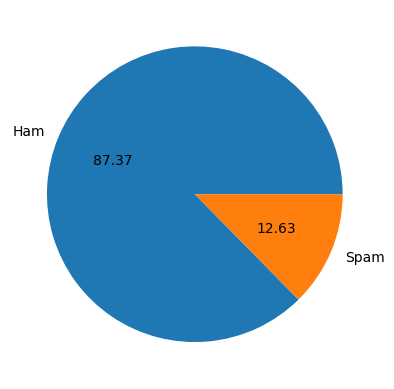

In [15]:
# Check the Target value using pie chart
plt.pie(df['v1'].value_counts(), labels=['Ham','Spam'],autopct='%.2f')
plt.show()

DATA PREPROCESSING

In [16]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
string.punctuation
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
def process_text(text):
  text=text.lower()

#tokenization
  text=nltk.word_tokenize(text)

# removing stopwords an punctuation
  x=[]
  for i in text:
      if i not in stopwords.words('english') and i not in string.punctuation:
        x.append(i)

  text=x[:]
  x.clear( )

  ps=PorterStemmer()
  for i in text:
    x.append(ps.stem(i))

  return " ".join(x)


In [18]:
df['Transformed_text']=df['v2'].apply(process_text)

In [19]:
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,Transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,go jurong point crazi .. avail bugi n great wo...
1,0,Ok lar... Joking wif u oni...,NaN,NaN,NaN,ok lar ... joke wif u oni ...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,NaN,NaN,NaN,u dun say earli hor ... u c alreadi say ...
4,0,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,nah n't think goe usf live around though


TF-IDF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
tfidf = TfidfVectorizer(max_features=3000)

In [22]:
# Fit and transform the 'Transformed_text' column
X = tfidf.fit_transform(df['Transformed_text'])


print("Shape of X:", X.shape)

Shape of X: (5169, 3000)


In [23]:
X.shape

(5169, 3000)

In [24]:
y = df['v1'].values

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
x_train,x_test,y_train,y_test = train_test_split(X.toarray(),y,test_size=0.2,random_state=2)

LOGISTIC REGRESSION

In [27]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
accuracy_score(y_train, lr.predict(x_train))

0.9717049576783555

In [28]:
accuracy_score(y_test, lr.predict(x_test))

0.9622823984526112

In [29]:
table_1={}
table_1["LOGISTIC REGRESSION"] = (accuracy_score(y_test, lr.predict(x_test)),
                               precision_score(y_test, lr.predict(x_test)),
                               recall_score(y_test, lr.predict(x_test)),
                               f1_score(y_test, lr.predict(x_test)))

SVM

In [30]:
svm= SVC()
svm.fit(x_train, y_train)
accuracy_score(y_train, svm.predict(x_train))

0.9975816203143894

In [31]:
accuracy_score(y_test, svm.predict(x_test))

0.97678916827853

In [32]:
table_1["SVM"] = (accuracy_score(y_test, svm.predict(x_test)),
                               precision_score(y_test, svm.predict(x_test)),
                               recall_score(y_test, svm.predict(x_test)),
                               f1_score(y_test, svm.predict(x_test)))

NAVIE BAYES

In [33]:
nb = GaussianNB()
nb.fit(x_train, y_train)
accuracy_score(y_train, nb.predict(x_train))

0.8948004836759371

In [34]:
accuracy_score(y_test, nb.predict(x_test))

0.8781431334622823

In [35]:
table_1["NAVIE BAYES"] = (accuracy_score(y_test, nb.predict(x_test)),
                               precision_score(y_test, nb.predict(x_test)),
                               recall_score(y_test, nb.predict(x_test)),
                               f1_score(y_test, nb.predict(x_test)))

In [36]:
pd.DataFrame(table_1, index=["accuracy", "precision", "recall", "f1score"])

,LOGISTIC REGRESSION,SVM,NAVIE BAYES
accuracy,0.962282,0.976789,0.878143
precision,0.980583,0.975000,0.526786
recall,0.731884,0.847826,0.855072
f1score,0.838174,0.906977,0.651934
